<a href="https://colab.research.google.com/github/TacticalCoders/NLP-with-Pytorch/blob/main/5_2_Word2Vec_CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBOW 임베딩 학습하기

범용 단어 임베딩을 구성하고 학습하는 유명한 모델, Word2Vec CBOW 모델을 만들어 보자.

이 절에서 언급하는 'CBOW (분류)작업'은 CBOW 임베딩을 학습하기 위한 분류 작업이다. CBOW 모델은 다중 분류 작업이다. 우선 단어 텍스트를 스캔하여 단어의 문맥 윈도를 만든 후 문맥 윈도에서 중앙의 단어를 제거하고 문맥 윈도를 사용해 누락된 단어를 예측한다.(빈칸 채우기와 비슷)

즉, 모델은 단어가 누락된 문장에서 누락 단어가 무엇인지 파악하는 역할을 한다.

임베딩 행렬을 캡슐화하는 파이토치 모듈 nn.Embedding 층을 사용해 토큰(단어)의 정수 ID를 신경망 계산에 사용되는 벡터로 매핑한다. 옵티마이저는 모델 가중치를 업데이트할 때 **이 벡터값도 업데이트**해서 손실을 최소화한다. 모델이 이 과정에서 해당 작업에 가장 유용한 방식으로 단어를 임베딩하는 방법을 배운다.

( 단어를 랜덤한 값을 가지는 밀집 벡터로 변환한 뒤에, 인공 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습 )

## Word2Vec의 CBOW 방식 

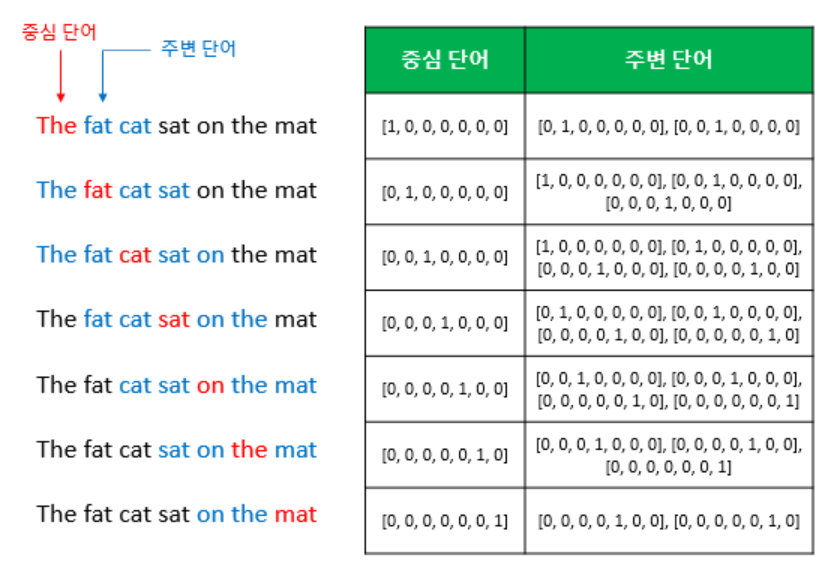

여기서 네번째 윈도우 "fat cat **sat** on the"는 아래의 그림처럼 주변부의 단어들(원-핫 벡터)이 입력된다. target('sat') 역시 원-핫 벡터 형태이다.

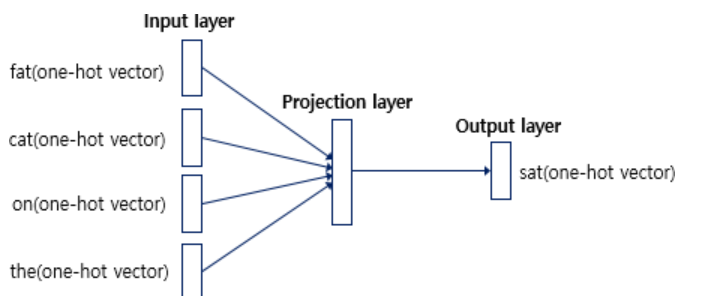

위 그림 처럼 CBOW 학습은 여러 층의 은닉층이 아니라 단 하나의 은닉층만 존재한다. 따라서 심층 신경망이 아니다. 

또한 일반적 은닉층과 달리 활성화 함수가 존재하지 않으며 룩업 테이블이라는 연산을 담당하는 층으로 일반적인 은닉층과 구분하기 위해 **투사층(projection layer)**이라고 부르기도 한다.

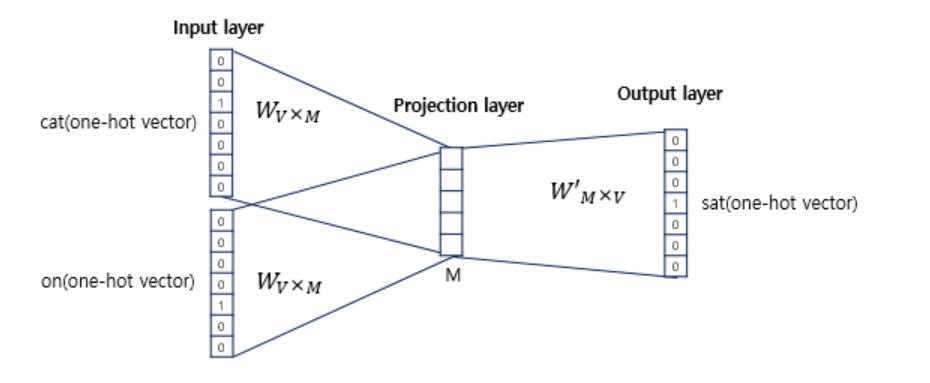

조금 더 확대해서 들여다보자.

우선 **투사층의 크기가 M**이다. CBOW에서 투사층의 크기 M은 임베딩하고 난 벡터의 차원이다. 다시 말해, 위의 그림에서 투사층의 크기는 M=5이기 때문에 CBOW를 수행하고나서 얻는 각 단어의 임베딩 벡터의 차원은 5가 된다.

또한 입력층과 투사층 사이의 가중치 W는 **V × M 행렬**이며, 투사층에서 출력층사이의 가중치 W'는 **M × V 행렬**이다. 여기서 V는 단어 집합의 크기를 의미한다. 즉, 위의 그림처럼 원-핫 벡터의 차원이 7이고, M은 5라면 가중치 W는 7 × 5 행렬이고, W'는 5 × 7 행렬이 된다. 주의할 점은 이 두 행렬은 동일한 행렬을 전치(transpose)한 것이 아니라, **서로 다른 행렬**이라는 점이다. 인공 신경망의 **훈련 전**에 이 가중치 행렬 W와 W'는**대게 굉장히 작은 랜덤 값**을 가지게 된다. CBOW는 주변 단어로 중심 단어를 더 정확히 맞추기 위해 **계속해서 이 W와 W'를 학습해가는 구조**이다.

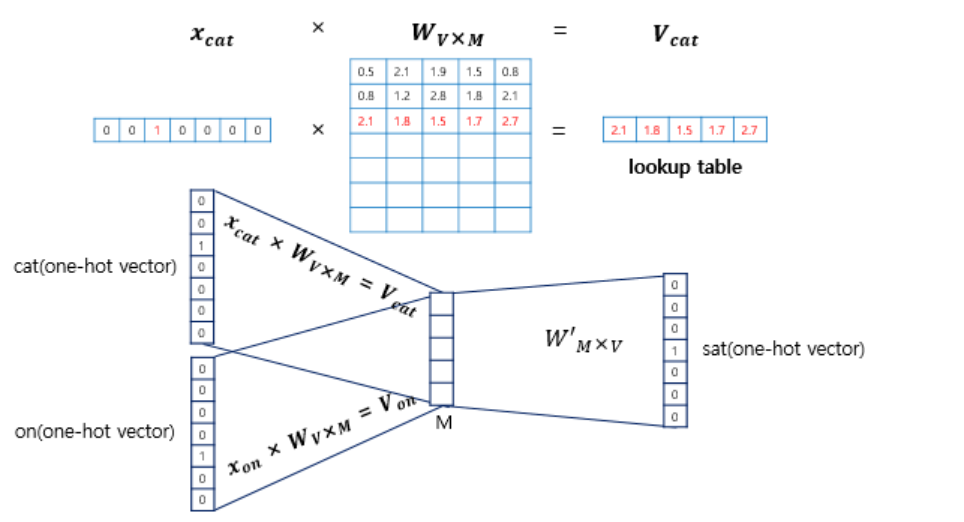

위 그림처럼 i번째 인덱스에 1이라는 값을 가지고 그 외의 0의 값을 가지는 입력 벡터와 가중치 W 행렬의 곱은 사실 W행렬의 i번째 행을 그대로 읽어오는 것과(lookup) 동일하다. 그래서 이 작업을 룩업 테이블(lookup table)이라고 부른다. CBOW의 목적은 W와 W'를 잘 훈련시키는 것인데, 사실 그 이유가 여기서 lookup해온 W의 각 행벡터가 사실 Word2Vec을 수행한 후의 각 단어의 M차원의 크기를 갖는 임베딩 벡터들이기 때문이다.

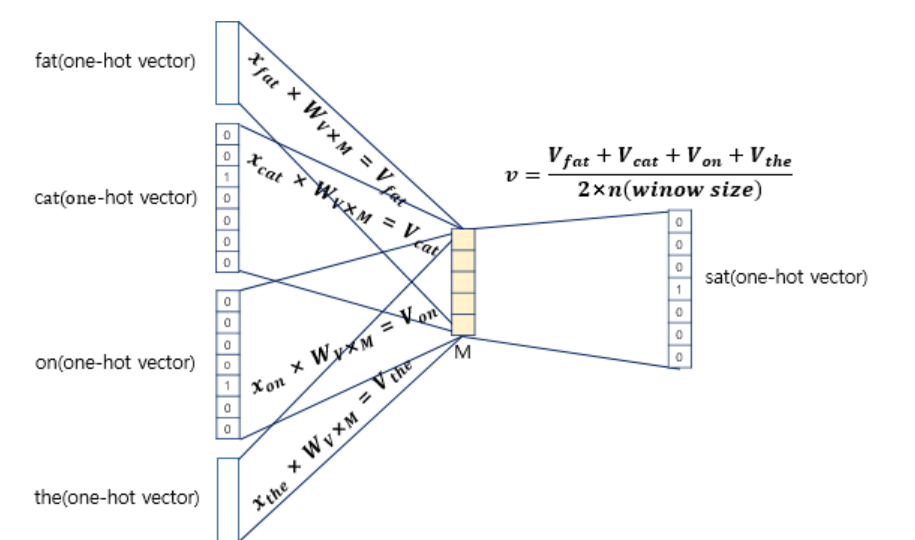

이렇게 각 주변 단어의 원-핫 벡터에 대해서 가중치 W가 곱해서 생겨진 결과 벡터들은 투사층에서 만나 이 벡터들의 평균인 벡터를 구하게 된다. 만약 윈도우 크기가 2라면, 입력 벡터의 총 개수는 2n이므로 중간 단어를 예측하기 위해서는 총 4개가 입력 벡터로 사용된다. 그렇기 때문에 평균을 구할 때는 4개의 결과 벡터에 대해서 평균을 구하게 된다. 

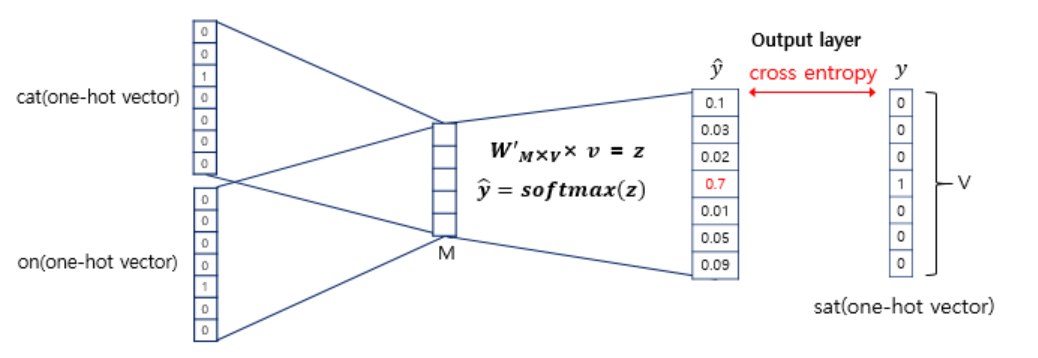

이렇게 구해진 평균 벡터는 두번째 가중치 행렬 W'와 곱해진다. 곱셈의 결과로는 원-핫 벡터들과 차원이 V로 동일한 벡터가 나온다. 만약 입력 벡터의 차원이 7이었다면 여기서 나오는 벡터도 7이다.

이 벡터에 CBOW는 소프트맥스(softmax) 함수를 취하는데, 소프트맥스 함수로 인한 출력값은 0과 1사이의 실수로, 각 원소의 총 합은 1이 되는 상태로 바뀐다. 이렇게 나온 벡터를 **스코어 벡터(score vector)**라고 한다. 스코어 벡터의 각 차원 안에서의 값이 의미하는 것은 스코어 j번째 단어(어휘집합의 'sat')가 **중심 단어일 확률**을 나타냅니다.

이 스코어 벡터는 우리가 실제로 값을 알고있는 벡터인 중심 단어 원-핫 벡터의 값(0.7이 1)에 가까워져야 한다. 스코어 벡터를 y^ 이라 하자. 중심 단어를 y로 했을 때, 이 두 벡터값의 오차를 줄이기위해 CBOW는 **손실 함수**(loss function)로 **cross-entropy 함수**를 사용한다.

이제 이 손실함수를 최소화하는 방향으로 역전파(Back Propagation)를 수행하면 W와 W'가 학습이 되는데, 학습이 다 되었다면 M차원의 크기를 갖는 W의 행이나 W'의 열로부터 어떤 것을 임베딩 벡터로 사용할지를 결정하면 된다. 때로는 W와 W'의 평균치를 가지고 임베딩 벡터를 선택하기도 한다.

## 프랑켄슈타인 데이터셋

메리 셸리의 소설 '프랑켄슈타인'의 디지털 버전을 받아 텍스트 데이터셋을 구축할 것이다. 전처리는 최소화한다.

NLTK의 Punkt 토큰 분할기를 사용해 텍스트를 **개별 문장으로 분할**한 다음 각 문장을 **소문자**로 변환하고 **구두점**을 완전히 **제거**한다.

이렇게 전처리를 한 다음 공백으로 문자열을 분할하면 토큰 리스트를 추출할 수 있다.

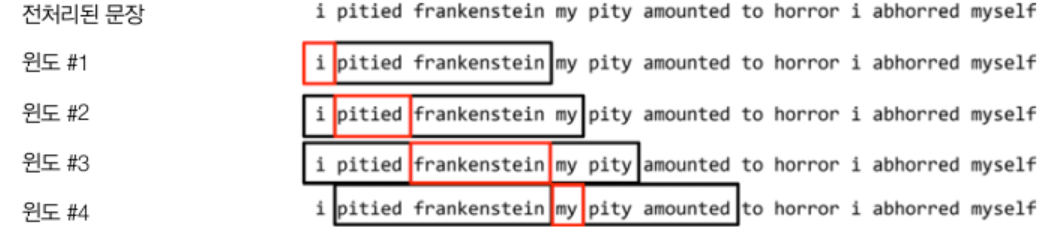

그 다음엔 각 문장의 토큰 리스트를 순회하면서 지정된 크기(양쪽으로 2)의 윈도로 묶는다. 

위 그림처럼 왼쪽 문맥과 오른쪽 문맥을 사용해 단어를 예측한다. 각 샘플의 타깃 단어는 가운데 단어(빨간 네모)이다.

만들어진 윈도 데이터셋과 타깃은 판다스 데이터프레임으로 로드되고 CBOWdataset 클래스에서 인덱싱된다.

In [6]:
# 데이터셋 다운(.txt)
!mkdir data
!wget https://git.io/JtX5A -O data/download.py
!wget https://git.io/JtX5F -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

--2022-07-11 01:00:23--  https://git.io/JtX5A
Resolving git.io (git.io)... 140.82.112.21
Connecting to git.io (git.io)|140.82.112.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_2_CBOW/data/download.py [following]
--2022-07-11 01:00:23--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_2_CBOW/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-07-11 01:00:23 (18.5 MB/s) - ‘data/download.py’ saved [1572/1572]

--2022-07-11 01:00:24--  https://git.io/JtX5F
Resolving 

In [1]:
import os

from argparse import Namespace
import collections
import nltk.data
import numpy as np
import pandas as pd
import re
import string
from tqdm import tqdm_notebook

In [2]:
args = Namespace(
    raw_dataset_txt="data/books/frankenstein.txt",
    window_size=5,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/books/frankenstein_with_splits.csv",
    seed=1337
)

In [7]:
# 개별 문장으로 분할
import nltk
nltk.download('punkt')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open(args.raw_dataset_txt) as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
print (len(sentences), "sentences")
print ("Sample:", sentences[100])

3427 sentences
Sample: No incidents have hitherto befallen us that would make a figure in a
letter.


총 3427 문장이 있는 것을 확인할 수 있다.

In [9]:
 # 소문자, 구두점 제거
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]

In [11]:
cleaned_sentences[0]

'frankenstein , or the modern prometheus by mary wollstonecraft godwin shelley letter st . petersburgh , dec . th , to mrs . saville , england you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings . '

In [10]:
# Global vars
MASK_TOKEN = "<MASK>"

In [12]:
# 윈도 생성
flatten = lambda outer_list: [item for inner_list in outer_list for item in inner_list]
windows = flatten([list(nltk.ngrams([MASK_TOKEN] * args.window_size + sentence.split(' ') + \
    [MASK_TOKEN] * args.window_size, args.window_size * 2 + 1)) \
    for sentence in tqdm_notebook(cleaned_sentences)])

# cbow data 생성
data = []
for window in tqdm_notebook(windows):
    target_token = window[args.window_size]
    context = []
    for i, token in enumerate(window):
        if token == MASK_TOKEN or i == args.window_size:
            continue
        else:
            context.append(token)
    data.append([' '.join(token for token in context), target_token])
    
            
# dataframe로 바꾸기.
cbow_data = pd.DataFrame(data, columns=["context", "target"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/3427 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/90698 [00:00<?, ?it/s]

In [13]:
# 훈련세트, 검증세트, 테스트세트로 분할
n = len(cbow_data)
def get_split(row_num):
    if row_num <= n*args.train_proportion:
        return 'train'
    elif (row_num > n*args.train_proportion) and (row_num <= n*args.train_proportion + n*args.val_proportion):
        return 'val'
    else:
        return 'test'
cbow_data['split']= cbow_data.apply(lambda row: get_split(row.name), axis=1)

In [14]:
cbow_data.head()

,context,target,split
0,", or the modern prometheus",frankenstein,train
1,frankenstein or the modern prometheus by,",",train
2,"frankenstein , the modern prometheus by mary",or,train
3,"frankenstein , or modern prometheus by mary wo...",the,train
4,"frankenstein , or the prometheus by mary wolls...",modern,train


위에 있는 target이 빈칸에 해당하는 단어이다.

In [15]:
cbow_data.to_csv(args.output_munged_csv, index=False) # 파일로 저장

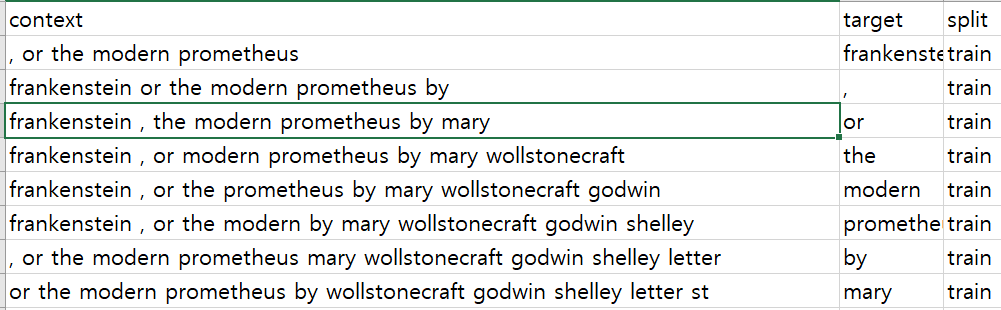

만들어진 데이터셋은 위 처럼 생겼다.

## Vocabulary

In [16]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [17]:
class Vocabulary(object):
    """ 매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
            mask_token (str): Vocabulary에 추가할 MASK 토큰.
                모델 파라미터를 업데이트하는데 사용하지 않는 위치를 나타냅니다.
            add_unk (bool): UNK 토큰을 추가할지 지정하는 플래그
            unk_token (str): Vocabulary에 추가할 UNK 토큰
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """ 토큰 리스트를 Vocabulary에 추가합니다.
        
        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.
        
        매개변수: 
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

## Vectorizer

여기서는 Vectorizer가 원-핫 벡터를 만드는 것이 아니라 문맥의 인덱스를 나타내는 정수 벡터를 만들어 반환한다.

문맥의 토큰 수가 최대 길이보다 적으면 나머지는 0으로 채워진다. 이를 0으로 **패딩**되었다고 한다.

In [18]:
class CBOWVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, cbow_vocab):
        """
        매개변수:
            cbow_vocab (Vocabulary): 단어를 정수에 매핑합니다
        """
        self.cbow_vocab = cbow_vocab

    def vectorize(self, context, vector_length=-1):
        """
        매개변수:
            context (str): 공백으로 나누어진 단어 문자열
            vector_length (int): 인덱스 벡터의 길이 매개변수
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.cbow_vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, cbow_df):
        """데이터셋 데이터프레임에서 Vectorizer 객체를 만듭니다
        
        매개변수::
            cbow_df (pandas.DataFrame): 타깃 데이터셋
        반환값:
            CBOWVectorizer 객체
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

    @classmethod
    def from_serializable(cls, contents):
        cbow_vocab = \
            Vocabulary.from_serializable(contents['cbow_vocab'])
        return cls(cbow_vocab=cbow_vocab)

    def to_serializable(self):
        return {'cbow_vocab': self.cbow_vocab.to_serializable()}

## Dataset

In [19]:
class CBOWDataset(Dataset):
    def __init__(self, cbow_df, vectorizer):
        """
        매개변수:
            cbow_df (pandas.DataFrame): 데이터셋
            vectorizer (CBOWVectorizer): 데이터셋에서 만든 CBOWVectorizer 객체
        """
        self.cbow_df = cbow_df
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))
        
        self.train_df = self.cbow_df[self.cbow_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.cbow_df[self.cbow_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.cbow_df[self.cbow_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, cbow_csv):
        """데이터셋을 로드하고 처음부터 새로운 Vectorizer 만들기
        
        매개변수:
            cbow_csv (str): 데이터셋의 위치
        반환값:
            CBOWDataset의 인스턴스
        """
        cbow_df = pd.read_csv(cbow_csv)
        train_cbow_df = cbow_df[cbow_df.split=='train']
        return cls(cbow_df, CBOWVectorizer.from_dataframe(train_cbow_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, cbow_csv, vectorizer_filepath):
        """ 데이터셋을 로드하고 새로운 CBOWVectorizer 객체를 만듭니다.
        캐시된 CBOWVectorizer 객체를 재사용할 때 사용합니다.
        
        매개변수:
            cbow_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): CBOWVectorizer 객체의 저장 위치
        반환값:
            CBOWVectorizer의 인스턴스
        """
        cbow_df = pd.read_csv(cbow_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(cbow_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 CBOWVectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer_filepath (str): 직렬화된 CBOWVectorizer 객체의 위치
        반환값:
            CBOWVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return CBOWVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """CBOWVectorizer 객체를 json 형태로 디스크에 저장합니다
        
        매개변수:
            vectorizer_filepath (str): CBOWVectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer
        
    def set_split(self, split="train"):
        """ 데이터프레임에 있는 열을 사용해 분할 세트를 선택합니다 """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드
        
        매개변수:
            index (int): 데이터 포인트의 인덱스
        반환값:
            데이터 포인트의 특성(x_data)과 레이블(y_target)로 이루어진 딕셔너리
        """
        row = self._target_df.iloc[index]

        context_vector = \
            self._vectorizer.vectorize(row.context, self._max_seq_length)
        target_index = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다
        
        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## 모델(CBOWClassifier)

모델은 세 가지 핵심 단계를 수행한다.



1.   Embedding 층을 사용해 문맥의 단어를 나타내는 인덱스를 각 단어에 대한 벡터로 만든다.
2.   전반적인 문맥을 감지하도록 벡터를 결합한다.(여기서는 더한다)
3.   Linear 층에서 문맥 벡터를 사용해 예측 벡터(전체 어휘 사전에 대한 확률 분포)를 계산한다.



In [20]:
class CBOWClassifier(nn.Module): # Simplified cbow Model
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        """
        매개변수:
            vocabulary_size (int): 어휘 사전 크기, 임베딩 개수와 예측 벡터 크기를 결정합니다
            embedding_size (int): 임베딩 크기
            padding_idx (int): 기본값 0; 임베딩은 이 인덱스를 사용하지 않습니다
        """
        super(CBOWClassifier, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings=vocabulary_size, 
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)
        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size)

    def forward(self, x_in, apply_softmax=False):
        """분류기의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서 
                x_in.shape는 (batch, input_dim)입니다.
            apply_softmax (bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스-엔트로피 손실을 사용하려면 False로 지정합니다
        반환값:
            결과 텐서. tensor.shape은 (batch, output_dim)입니다.
        """
        x_embedded_sum = F.dropout(self.embedding(x_in).sum(dim=1), 0.3)
        y_out = self.fc1(x_embedded_sum)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out

## 훈련

### 헬퍼 함수

In [21]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### 일반 유틸리티

In [22]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### 설정 및 전처리

In [23]:
args = Namespace(
    # 날짜와 경로 정보
    cbow_csv="data/books/frankenstein_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch5/cbow",
    # 모델 하이퍼파라미터
    embedding_size=50,
    # 훈련 하이퍼파라미터
    seed=1337,
    num_epochs=100,
    learning_rate=0.0001,
    batch_size=32,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	model_storage/ch5/cbow/vectorizer.json
	model_storage/ch5/cbow/model.pth
CUDA 사용여부: False


### 데이터 준비(초기화)

In [24]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 라이트 버전의 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/JtX5A -O data/download.py
!wget https://git.io/JtX5F -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

mkdir: cannot create directory ‘data’: File exists
--2022-07-11 01:27:43--  https://git.io/JtX5A
Resolving git.io (git.io)... 140.82.114.21
Connecting to git.io (git.io)|140.82.114.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_2_CBOW/data/download.py [following]
--2022-07-11 01:27:43--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_5/5_2_CBOW/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2022-07-11 01:27:43 (20.8 MB/s) - ‘data/download.py’ saved [1572/1572]

--202

In [25]:
if args.reload_from_files:
    print("데이터셋과 Vectorizer를 로드합니다")
    dataset = CBOWDataset.load_dataset_and_load_vectorizer(args.cbow_csv,
                                                           args.vectorizer_file)
else:
    print("데이터셋을 로드하고 Vectorizer를 만듭니다")
    dataset = CBOWDataset.load_dataset_and_make_vectorizer(args.cbow_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = CBOWClassifier(vocabulary_size=len(vectorizer.cbow_vocab), 
                            embedding_size=args.embedding_size)

데이터셋을 로드하고 Vectorizer를 만듭니다


### 훈련 반복

In [26]:
classifier = classifier.to(args.device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size), 
                               position=1, 
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size), 
                             position=1, 
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------
            
            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 바 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier(x_in=batch_dict['x_data'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/1984 [00:00<?, ?it/s]

split=val:   0%|          | 0/425 [00:00<?, ?it/s]

In [27]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [28]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 8.193071616677674;
테스트 정확도: 11.411764705882353


정확도가 매우 낮다. 그 이유는 다음과 같다.

이 예제에서는 (성능 최적화에 필수적인) 여러 기능을 생략해서 간단하게 CBOW룰 만들었다. 

또한 여기서 사용하는 데이터셋은 아주 작다. 70,000개의 단어가 포함된 책 한권은 많은 규칙성을 감지하기에 충분한 데이터가 아니다. 최첨단 임베딩은 일반적으로 테라바이트 규모의 텍스트로 이루어진 데이터셋에서 훈련된다.(커먼 크롤 데이터셋은 100TB가 넘는다)

## 훈련된 임베딩

In [29]:
def pretty_print(results):
    """
    임베딩 결과를 출력합니다
    """
    for item in results:
        print ("...[%.2f] - %s"%(item[1], item[0]))

def get_closest(target_word, word_to_idx, embeddings, n=5):
    """
    n개의 최근접 단어를 찾습니다.
    """

    # 다른 모든 단어까지 거리를 계산합니다
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    results = sorted(distances, key=lambda x: x[1])[1:n+2]
    return results

In [31]:
word = input('단어를 입력해 주세요: ')
embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx
pretty_print(get_closest(word, word_to_idx, embeddings, n=5))

단어를 입력해 주세요: happy
...[6.29] - wand
...[6.38] - injury
...[6.48] - penetrated
...[6.49] - chivalry
...[6.53] - danger
...[6.54] - altered


In [32]:
target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy']

embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx

for target_word in target_words: 
    print(f"======={target_word}=======")
    if target_word not in word_to_idx:
        print("Not in vocabulary")
        continue
    pretty_print(get_closest(target_word, word_to_idx, embeddings, n=5))

=======frankenstein=======
...[6.92] - discrimination
...[7.02] - oppressive
...[7.06] - spurned
...[7.06] - slight
...[7.08] - wandering
...[7.10] - illustrate
=======monster=======
...[7.34] - cares
...[7.56] - griefs
...[7.60] - prolong
...[7.63] - trifling
...[7.64] - sickness
...[7.69] - saw
=======science=======
...[6.88] - mutual
...[6.91] - mist
...[7.01] - impression
...[7.01] - swelling
...[7.04] - nearly
...[7.06] - darkened
=======sickness=======
...[6.36] - while
...[6.44] - foundations
...[6.64] - consoles
...[6.66] - awoke
...[6.71] - know
...[6.71] - depend
=======lonely=======
...[6.70] - unveiled
...[6.85] - moonlight
...[7.05] - bed
...[7.07] - ought
...[7.13] - superhuman
...[7.14] - heartily
=======happy=======
...[6.29] - wand
...[6.38] - injury
...[6.48] - penetrated
...[6.49] - chivalry
...[6.53] - danger
...[6.54] - altered
